In [1]:
import pandas as pd
import seaborn as sns
import os
import calendar
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import LabelEncoder

In [2]:
def generate_filtered_csv(file_num, filtered_file_name):
    file_name = "src_elo7/yellow_tripdata_2020-{:02}.csv".format(file_num)
    temp_dataset = pd.read_csv(file_name)[['tpep_pickup_datetime',
                                           'tpep_dropoff_datetime',
                                           'passenger_count',
                                           'PULocationID',
                                           'DOLocationID']]
    file_new_name = filtered_file_name
    temp_dataset.to_csv(file_new_name)

for file_num in range(1,13):
    filtered_file_name = "src_elo7/yellow_tripdata_filtered_2020-{:02}.csv".format(file_num)
    if not os.path.isfile(filtered_file_name):
        generate_filtered_csv(file_num, filtered_file_name)

In [3]:
dataset_bairros = pd.read_csv('src_elo7/taxi_zone_lookup.csv')
dataset_bairros

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


# 1. Limpeza da base

- Existem datas de início da viagem cujo o ano é diferente de 2020

In [4]:
def check_dataset_years():
    years_values = pd.Series()
    start_time = datetime.now() 
    for file_num in range(1,13):
        file_name = "src_elo7/yellow_tripdata_filtered_2020-{:02}.csv".format(file_num)
        temp_dataset = pd.read_csv(file_name)
        temp_dataset['tpep_pickup_datetime'] = pd.to_datetime(temp_dataset['tpep_pickup_datetime'])
        temp_dataset['tpep_dropoff_datetime'] = pd.to_datetime(temp_dataset['tpep_dropoff_datetime'])
        years_values = years_values.add(temp_dataset['tpep_pickup_datetime'].dt.year.value_counts(), fill_value=0)
    end_time = datetime.now()
    print(years_values.sort_values(ascending=False))
    print("Tempo de processamento - check_dataset_years:",end_time-start_time)
    
check_dataset_years()

<ipython-input-4-d36827bdc3eb>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  years_values = pd.Series()


2020    24648219.0
2019         131.0
2009          90.0
2008          32.0
2021          24.0
2003           2.0
2002           1.0
dtype: float64
Tempo de processamento - check_dataset_years: 0:00:53.433016


In [5]:
def get_filtered_dataset(columns=None, first_file=1, last_file=12):
    if columns is None:
        columns_to_filter = ['tpep_pickup_datetime']
    else:
        columns_to_filter = columns
    dataset = pd.DataFrame()
    start_time = datetime.now() 
    for file_num in range(first_file,last_file+1):
        file_name = "src_elo7/yellow_tripdata_filtered_2020-{:02}.csv".format(file_num)
        temp_dataset = pd.read_csv(file_name)[columns_to_filter]
        temp_dataset['tpep_pickup_datetime'] = pd.to_datetime(temp_dataset['tpep_pickup_datetime'])
        temp_dataset = temp_dataset[temp_dataset['tpep_pickup_datetime'].dt.year == 2020]
        dataset = pd.concat([dataset, temp_dataset])
    end_time = datetime.now()
    print("Tempo de processamento - get_filtered_dataset:",end_time-start_time)
    return dataset

# 2. Perguntas de negócio

### 2.1 Em que período do ano os táxis são mais utilizados? Demonstre através de gráficos os bairros que possuem maior uso de táxis por mês.

In [6]:
def get_month_index(month):
    month_dict = {'January':1,
         'February':2,
         'March':3,
         'April':4,
         'May':5,
         'June':6,
         'July':7,
         'August':8,
         'September':9,
         'October':10,
         'November':11,
         'December':12}
    return month_dict[month]

Tempo de processamento - get_filtered_dataset: 0:00:39.535177
Tempo de processamento - get_monthly_usage: 0:00:48.324658


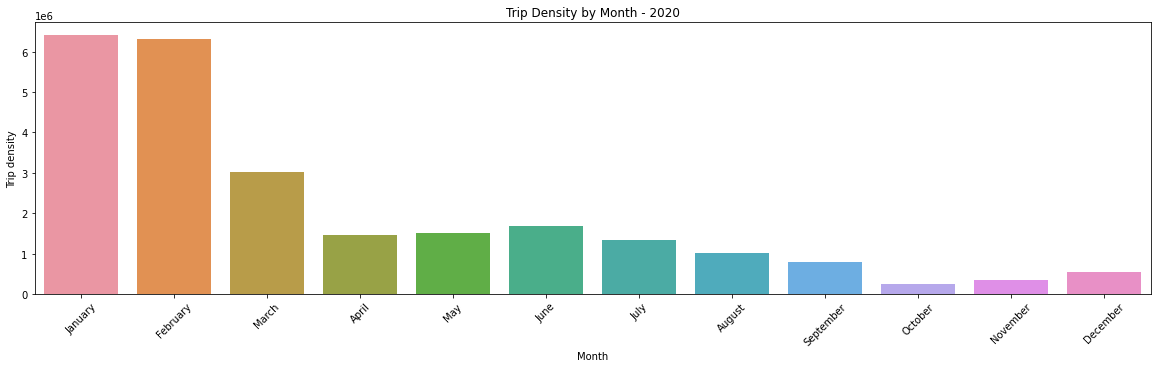

In [7]:
def get_monthly_usage():
    start_time = datetime.now() 
    dataset = get_filtered_dataset()
    n_trips_by_month = dataset['tpep_pickup_datetime'].dt.month.value_counts().to_frame().sort_index().copy()
    n_trips_by_month['month'] = dataset['tpep_pickup_datetime'].dt.month_name().value_counts().index
    n_trips_by_month['month_id'] = 0
    n_trips_by_month.reset_index(inplace=True)
    n_trips_by_month.drop(columns=['index'], axis=1, inplace=True)
    for row_index in range(n_trips_by_month.shape[0]):  
        n_trips_by_month.iloc[row_index:row_index+1,-1:] = get_month_index(n_trips_by_month.loc[row_index]['month'])
    end_time = datetime.now()
    print("Tempo de processamento - get_monthly_usage:",end_time-start_time)
    return n_trips_by_month.sort_values(by=['month_id'])   
    
n_trips_by_month = get_monthly_usage()
plt.figure(figsize=(20,5))
h = sns.barplot(x=n_trips_by_month['month'], y=n_trips_by_month['tpep_pickup_datetime'])
h.set_yscale("linear")
plt.xticks(rotation=45)
plt.title('Trip Density by Month - 2020')
plt.ylabel('Trip density')
plt.xlabel('Month')
plt = plt

Tempo de processamento - get_filtered_dataset: 0:00:39.504512
Tempo de processamento - get_list_monthly_usage_by_borough: 0:00:50.697548


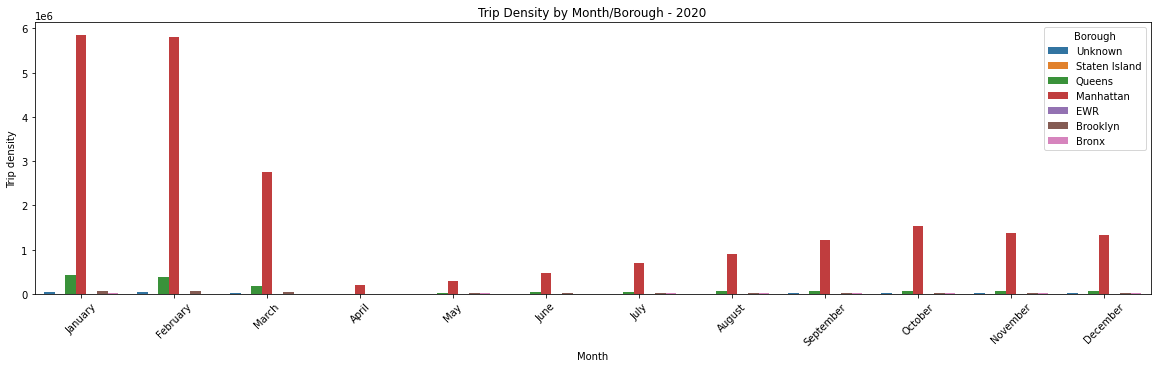

In [8]:
def get_list_monthly_usage_by_borough():
    start_time = datetime.now() 
    dataset = get_filtered_dataset(['PULocationID', 'tpep_pickup_datetime'])
    
    #Join para obter os nomes dos bairros
    dataset_month_borough = dataset.join(dataset_bairros
                                         .rename(columns={'LocationID':'PULocationID'}).set_index('PULocationID'),
                                         on='PULocationID')[['tpep_pickup_datetime','Borough']]
    #Obter o nome do mês
    dataset_month_borough['tpep_pickup_datetime'] = dataset_month_borough['tpep_pickup_datetime'].dt.month_name()
    #Qtd por mês de viagem por bairro
    dataset = dataset_month_borough.groupby(by=['tpep_pickup_datetime','Borough']).size().reset_index(name='count')
    dataset['month_id'] = 0
    for row_index in range(dataset.shape[0]):  
        dataset.loc[row_index,'month_id'] = get_month_index(dataset.loc[row_index]['tpep_pickup_datetime'])
    end_time = datetime.now()
    print("Tempo de processamento - get_list_monthly_usage_by_borough:",end_time-start_time)
    return dataset.sort_values(by=['month_id'])

dataset = get_list_monthly_usage_by_borough()
plt.figure(figsize=(20,5))
sns.barplot(x='tpep_pickup_datetime', y='count', hue=dataset['Borough'], data=dataset)
plt.xticks(rotation=45)
plt.title('Trip Density by Month/Borough - 2020')
plt.ylabel('Trip density')
plt.xlabel('Month')
plt = plt

### 2.2 Em quais janela de tempo as viagens contém mais passageiros? Demonstre através de gráficos os bairros que possuem maior número de passageiros por janela de tempo. Utilize as janelas abaixo:
- 0 as 5 (4:59)
- 5 as 11
- 11 as 14
- 14 as 17
- 17 as 21
- 21 as 24

Tempo de processamento - get_filtered_dataset: 0:00:02.143289


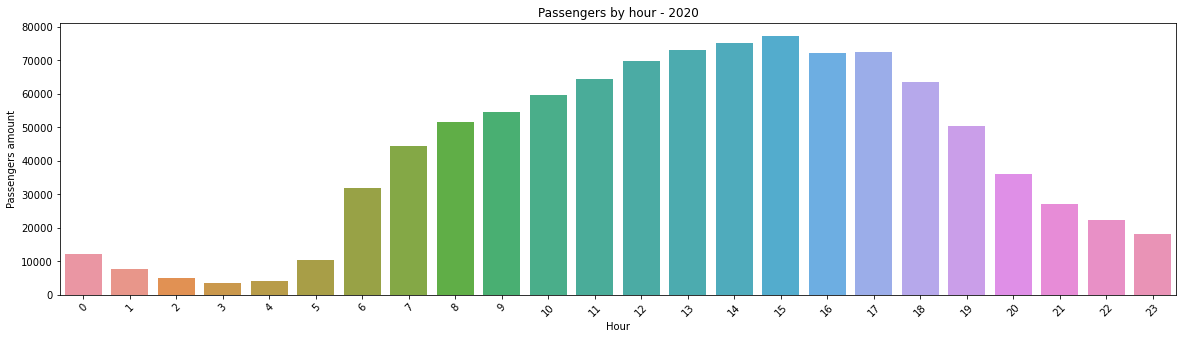

In [9]:
def get_list_hourly_usage_by_borough():
    dataset = get_filtered_dataset(['PULocationID','passenger_count','tpep_pickup_datetime'],
                                  first_file=4,
                                  last_file=6)
    dataset.dropna(inplace=True)
    #Join para obter os nomes dos bairros
    dataset_month_borough = dataset.join(dataset_bairros
                                         .rename(columns={'LocationID':'PULocationID'}).set_index('PULocationID'),
                                         on='PULocationID')[['tpep_pickup_datetime','Borough','passenger_count']]
    dataset_month_borough['tpep_pickup_datetime'] = dataset_month_borough['tpep_pickup_datetime'].dt.hour
    return dataset_month_borough
dataset = get_list_hourly_usage_by_borough()

hour_rate = dataset.groupby(by=['tpep_pickup_datetime']).count()['passenger_count'].to_frame().reset_index()
plt.figure(figsize=(20,5))
sns.barplot(x='tpep_pickup_datetime', y='passenger_count', data=hour_rate)
plt.xticks(rotation=45)
plt.title('Passengers by hour - 2020')
plt.ylabel('Passengers amount')
plt.xlabel('Hour')
plt = plt

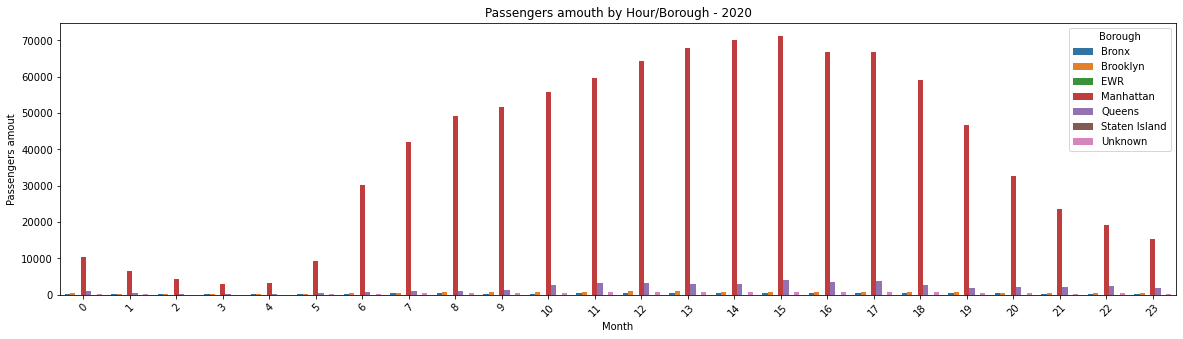

In [10]:
hour_rate_borough = dataset.groupby(by=['tpep_pickup_datetime','Borough']).count()['passenger_count'].to_frame().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(x='tpep_pickup_datetime', y='passenger_count', hue=hour_rate_borough['Borough'], data=hour_rate_borough)
plt.xticks(rotation=45)
plt.title('Passengers amouth by Hour/Borough - 2020')
plt.ylabel('Passengers amout')
plt.xlabel('Month')
plt = plt

### 2.3 Descreva como você faria para agendar a execução diaria e/ou mensal destes jobs.

- Agendaria um job através de uma instância EC2, conforme a quantidade de tabelas fosse crescendo, analisaria se faria sentido ficar concatenando as bases conforme visto na implementação, ou se executaria queries em paralelo e depois as somaria. Tem a possibilidade de usar o Spark também.

### 2.4 Bonus: este desafio é opicional. Como a distância se correlaciona com a duração das viagens? Demonstre através de gráficos essa correlação

In [11]:
label_encoder = LabelEncoder()
dataset["Borough"] = label_encoder.fit_transform(dataset["Borough"])

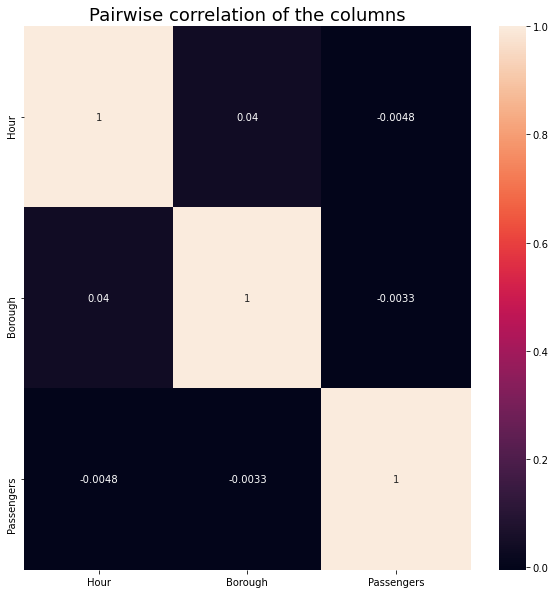

In [12]:
dataset.rename(columns={'tpep_pickup_datetime':'Hour', 'passenger_count': 'Passengers'}, inplace=True)
fig, ax = plt.subplots(figsize = (10, 10))
plt.title("Pairwise correlation of the columns", fontsize = 18)
ax = sns.heatmap(dataset.corr(), annot = True)

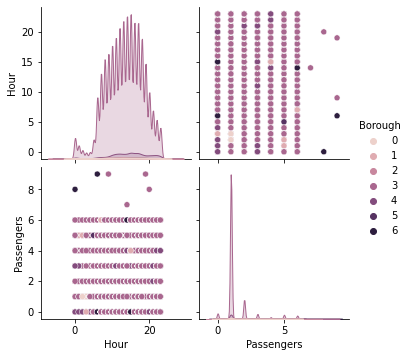

In [13]:
sns.pairplot(dataset, hue = "Borough")
plt.show()